## Model Klaim Asuransi Kesehatan dengan Sklearn

## Business Context

Dataset ini berisi informasi terkait klaim asuransi kesehatan yang mencakup berbagai fitur terkait pasien, penyedia layanan kesehatan, dan status klaim. Data ini penting untuk dianalisis dalam rangka memprediksi status klaim, yang dapat membantu perusahaan asuransi dalam menentukan keputusan lebih cepat dan efisien.

## Problem Statement

Mengingat klaim asuransi sangat penting dalam industri kesehatan, prediksi status klaim (approved, denied, pending) akan membantu mempercepat proses persetujuan klaim, meningkatkan efisiensi, dan mengurangi biaya administratif. Oleh karena itu, kita ingin membuat model yang dapat memprediksi status klaim berdasarkan fitur-fitur yang ada.

## Goals

- Membangun model klasifikasi untuk memprediksi status klaim (ClaimStatus), apakah klaim tersebut Approved atau Denied.
- Memahami pengaruh faktor-faktor seperti usia pasien, pendapatan, status perkawinan, dan lainnya terhadap hasil klaim.


## Evaluasi Metrik

### 1. False Negative (FN)
Definisi: Model memprediksi **tidak klaim (0)**, tetapi sebenarnya pelanggan melakukan **klaim (1)**.
Dampak:
Klaim yang valid tidak terdeteksi.
Pelanggan merasa dirugikan karena klaim mereka tidak diproses.
Risiko kehilangan kepercayaan pelanggan terhadap perusahaan.
Potensi pelanggaran kontrak atau hukum.
Mengapa FN harus dikurangi? Dalam industri asuransi, mendeteksi klaim yang valid sangat penting untuk menjaga reputasi perusahaan dan kepatuhan terhadap polis.

### 2. False Positive (FP)
Definisi: Model memprediksi **klaim (1)**, tetapi sebenarnya pelanggan **tidak melakukan klaim (0)**.
Dampak:
Sumber daya digunakan untuk memproses klaim yang sebenarnya tidak ada.
Biaya tambahan untuk penyelidikan klaim palsu.
Risiko pembayaran klaim yang tidak valid jika investigasi tidak dilakukan dengan benar.
Mengapa FP juga penting dikurangi? Mengurangi FP membantu perusahaan meminimalkan biaya operasional dan mencegah penipuan klaim.

## Alasan menggunakan Accuracy
Karena dataset asuransi memiliki jumlah yang seimbang antara klaim (1) dan tidak klaim (0), kita dapat menggunakan Accuracy untuk memilih model yang paling baik.

<!-- 
### Fokus Utama: FN atau Keduanya?
**Jika fokus bisnis adalah meminimalkan kerugian pelanggan**:
- Prioritaskan mengurangi FN.
- Misalnya, untuk mendeteksi klaim valid yang terlewat, recall (True Positive Rate) harus tinggi.

**Jika fokus bisnis adalah efisiensi biaya**:
- Kurangi FN dan FP secara seimbang.
- Kombinasi antara presisi dan recall melalui F1 Score dapat membantu memastikan:
- - Klaim yang valid dideteksi (mengurangi FN).
- - Klaim palsu diminimalkan (mengurangi FP).

### Alasan Utama Menggunakan F1-Score
1. Penanganan Dataset Tidak Seimbang

- Pada dataset prediksi klaim asuransi, biasanya jumlah **klaim yang valid (Claimed = 1)** jauh lebih sedikit dibandingkan **klaim yang tidak ada (Claimed = 0)**.
- Akurasi saja bisa menyesatkan dalam kasus ini. Contoh: Jika model selalu memprediksi "tidak klaim", akurasi bisa tetap tinggi meskipun model gagal mendeteksi klaim valid.

2. Keseimbangan antara False Negative (FN) dan False Positive (FP)

- **FN (False Negative)**: Klaim valid yang tidak terdeteksi dapat merugikan pelanggan, merusak kepercayaan, dan melanggar perjanjian polis. Oleh karena itu, mengurangi FN sangat penting.
- **FP (False Positive)**: Klaim palsu yang terdeteksi dapat meningkatkan biaya operasional perusahaan. Maka, penting juga untuk meminimalkan FP.
- **F1-Score** menghitung harmoni antara presisi dan recall, sehingga mampu memberikan penilaian yang lebih adil ketika kedua jenis kesalahan ini harus dipertimbangkan. -->



In [34]:
# !pip install scikit-learn imbalanced-learn xgboost pandas

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


## Load Dataset

In [36]:
# Data loading and preparation
df = pd.read_csv('./dataset/enhanced_health_insurance_claims.csv')

In [37]:
df.head()

,ClaimID,PatientID,ProviderID,ClaimAmount,ClaimDate,DiagnosisCode,ProcedureCode,PatientAge,PatientGender,ProviderSpecialty,ClaimStatus,PatientIncome,PatientMaritalStatus,PatientEmploymentStatus,ProviderLocation,ClaimType,ClaimSubmissionMethod
0,10944daf-f7d5-4e1d-8216-72ffa609fe41,8552381d-7960-4f64-b190-b20b8ada00a1,4a4cb19c-4863-41cf-84b0-c2b21aace988,3807.95,2024-06-07,yy006,hd662,16,M,Cardiology,Pending,90279.43,Married,Retired,Jameshaven,Routine,Paper
1,fcbebb25-fc24-4c0f-a966-749edcf83fb1,327f43ad-e3bd-4473-a9ed-46483a0a156f,422e02dd-c1fd-43dd-8af4-0c3523f997b1,9512.07,2023-05-30,tD052,mH831,27,M,Pediatrics,Approved,130448.02,Single,Student,Beltrantown,Routine,Online
2,9e9983e7-9ea7-45f5-84d8-ce49ccd8a4a1,6f3acdf7-73aa-4afa-9c2e-b25b27bdb5b0,f7733b3f-0980-47b5-a7a0-ee390869355b,7346.74,2022-09-27,zx832,dg637,40,F,Cardiology,Pending,82417.54,Divorced,Employed,West Charlesport,Emergency,Online
3,a06273ed-44bb-452b-bbad-8618de080494,5d58e183-701e-406c-a8c6-5b73cac5e912,f7a04581-de96-44ee-b773-8adac02baa59,6026.72,2023-06-25,kr421,kG326,65,M,Neurology,Pending,68516.96,Widowed,Student,West Aprilhaven,Routine,Phone
4,f702a717-254b-4cff-a0c7-8395db2f6616,8a8ebdf6-3af0-4f14-82f3-37b937c3d270,b80b9e77-97f0-47d7-b561-19f9658a7bdf,1644.58,2023-07-24,LZ261,cx805,24,M,General Practice,Pending,84122.17,Married,Student,Lake Michele,Inpatient,Phone


In [38]:
df["ClaimStatus"].value_counts()

ClaimStatus
Approved    1522
Denied      1512
Pending     1466
Name: count, dtype: int64

In [39]:
df = df[df['ClaimStatus'] != 'Pending']

In [40]:
df_description = []

for i in df.columns:
    df_description.append([i,df[i].dtypes,
                    df[i].isna().sum(),
                    round((df[i].isna().sum()/len(df)*100),2),
                    df[i].nunique(),
                    df[i].sample(3).values])

df_info = pd.DataFrame(df_description, columns = ['kolom', 'tipe data', 'null', 'null_persentase', 'jumlah_unik','sample_unik'])
df_info

,kolom,tipe data,null,null_persentase,jumlah_unik,sample_unik
0,ClaimID,object,0,0.0,3034,"[36d338a2-a034-4665-8110-32d6bddf69a8, 04d49c1..."
1,PatientID,object,0,0.0,3034,"[fe1d11fc-edfc-4a7e-9885-488c6df3a577, ea3d849..."
2,ProviderID,object,0,0.0,3034,"[d4b151e0-e77c-4946-8821-f5b4d0891980, fcd7240..."
3,ClaimAmount,float64,0,0.0,3030,"[2227.91, 3446.15, 432.77]"
4,ClaimDate,object,0,0.0,721,"[2022-07-19, 2023-05-21, 2023-01-11]"
5,DiagnosisCode,object,0,0.0,3031,"[HK800, NN047, qV662]"
6,ProcedureCode,object,0,0.0,3031,"[iY164, CW709, Xk558]"
7,PatientAge,int64,0,0.0,100,"[89, 27, 66]"
8,PatientGender,object,0,0.0,2,"[M, F, M]"
9,ProviderSpecialty,object,0,0.0,5,"[General Practice, General Practice, Cardiology]"


In [41]:
!pip install seaborn

In [42]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

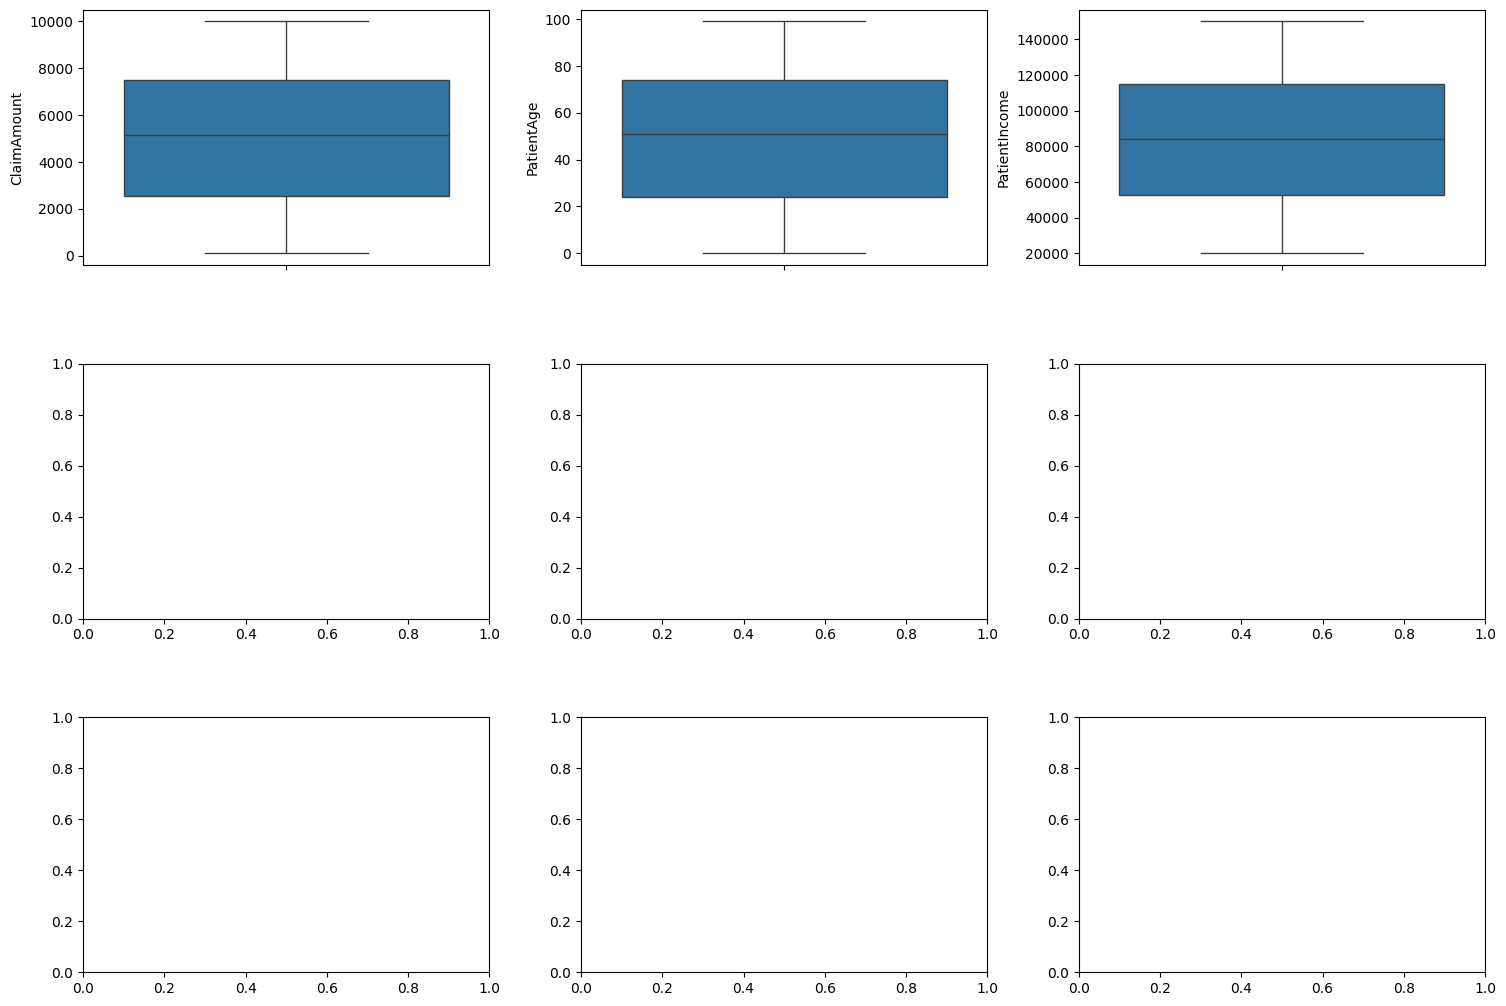

In [43]:
# Check Outliers kolom numerik
df_numerik = df.select_dtypes(include=[float, int]).columns

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15,10))
index = 0
ax = ax.flatten()

for kolom in df_numerik:
    sns.boxplot(y=kolom, data=df, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

plt.show()

In [44]:
# Checking is there any data duplicates
df.duplicated().sum()

np.int64(0)

In [45]:
df.isna().sum()

ClaimID                    0
PatientID                  0
ProviderID                 0
ClaimAmount                0
ClaimDate                  0
DiagnosisCode              0
ProcedureCode              0
PatientAge                 0
PatientGender              0
ProviderSpecialty          0
ClaimStatus                0
PatientIncome              0
PatientMaritalStatus       0
PatientEmploymentStatus    0
ProviderLocation           0
ClaimType                  0
ClaimSubmissionMethod      0
dtype: int64

In [46]:
df.isna().sum()/df.shape[0]*100

ClaimID                    0.0
PatientID                  0.0
ProviderID                 0.0
ClaimAmount                0.0
ClaimDate                  0.0
DiagnosisCode              0.0
ProcedureCode              0.0
PatientAge                 0.0
PatientGender              0.0
ProviderSpecialty          0.0
ClaimStatus                0.0
PatientIncome              0.0
PatientMaritalStatus       0.0
PatientEmploymentStatus    0.0
ProviderLocation           0.0
ClaimType                  0.0
ClaimSubmissionMethod      0.0
dtype: float64

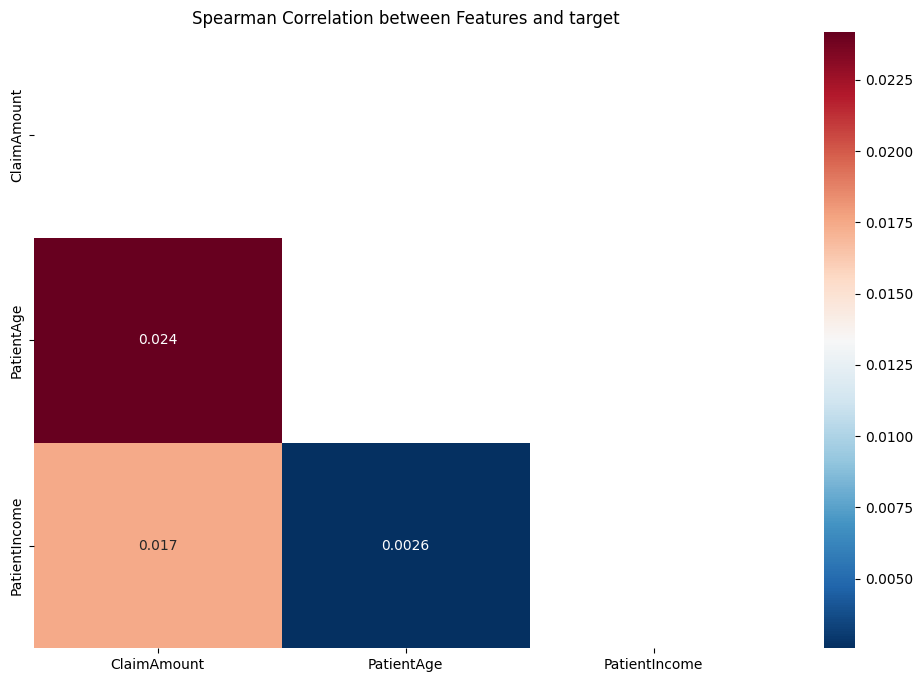

In [47]:
# Mengambil hanya kolom-kolom numerik dari DataFrame df
# Filter only numerical columns
df_numeric = df.select_dtypes(include=['number'])

# Menghitung korelasi Spearman
corr_spearman = df_numeric.corr(method='spearman')

# Mengubah elemen-elemen di bawah diagonal utama menjadi NaN
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))

# Membuat Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_spearman, cmap="RdBu_r", annot=True, mask=mask)

plt.title('Spearman Correlation between Features and target')
plt.show()

In [48]:
# Define features and target
X = df.drop('ClaimStatus', axis=1)
y = df['ClaimStatus']
# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [49]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Preprocessing for numerical and categorical data
numeric_features = ['PatientAge', 'ClaimAmount', 'PatientIncome']
categorical_features = ['PatientGender', 'ProviderSpecialty', 'ClaimType', 'ClaimSubmissionMethod', 'PatientMaritalStatus', 'PatientEmploymentStatus']

In [51]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # to fill missing values with median
    ('scaler', StandardScaler()) # to scale numerical features
    # ('scaler', RobustScaler()) # to scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # to fill missing values with most frequent category
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # only 2 categories
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [52]:
# Models to evaluate
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

voting = VotingClassifier(estimators=[('logreg', logreg), ('knn', knn), ('tree', tree)], voting='hard')
stacking = StackingClassifier(estimators=[('logreg', logreg), ('knn', knn)], final_estimator=DecisionTreeClassifier())

models = [logreg, knn, tree, voting, stacking, xgb]

# Resampling options: SMOTE and NearMiss
resampling = [SMOTE(sampling_strategy='auto', random_state=42), NearMiss(sampling_strategy='auto')]

In [53]:
# Hyperparameter tuning with GridSearchCV

# param grid untuk XGB
param_grid = { 
    'resampling': [SMOTE(sampling_strategy='auto', random_state=42)],  # Gunakan SMOTE
    'classifier__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'classifier__n_estimators': [100, 200],  # Jumlah estimators (pohon)
    'classifier__max_depth': [3, 6, 10]  # Kedalaman pohon
}

# param grid untuk random forest
# param_grid = {
#     'resampling': [SMOTE(sampling_strategy='auto', random_state=42)],  # Gunakan SMOTE
#     'classifier__n_estimators': [100, 200],  # Jumlah pohon
#     'classifier__max_depth': [None, 10, 20],  # Kedalaman pohon
#     'classifier__min_samples_split': [2, 5]  # Pembagian minimum sampel
# }

# param grid untuk logreg
# param_grid = {
#     'resampling': [SMOTE(sampling_strategy='auto', random_state=42)],  # Gunakan hanya SMOTE
#     'classifier__C': [0.1, 1, 10],  # Parameter Logistic Regression
#     'classifier__penalty': ['l2'],  # Regularization
#     'classifier__solver': ['lbfgs']  # Solver untuk Logistic Regression
# }




In [54]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.5.2

In [55]:
# !pip install scikit-learn==1.1.3

In [56]:
results = {}

In [57]:
# Cross-validation and evaluation
for model in models:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('resampling', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE as default resampling
                                  ('classifier', model)])
    
    # Evaluate model with cross-validation (F1-score)
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    results[model.__class__.__name__] = cv_results.mean()

In [58]:
# Print results of cross-validation
for model_name, score in results.items():
    # print(f"{model_name}: F1-Score (CV) = {score}")
    print(f"{model_name}: Accuracy (CV) = {score}")

# Best model selection based on F1-score
best_model_name = max(results, key=results.get)
print(f"Model terbaik berdasarkan Accuracy: {best_model_name}")

LogisticRegression: Accuracy (CV) = 0.5150362733867888
KNeighborsClassifier: Accuracy (CV) = 0.5142140766195749
DecisionTreeClassifier: Accuracy (CV) = 0.4997887234313351
VotingClassifier: Accuracy (CV) = 0.5113317211828093
StackingClassifier: Accuracy (CV) = 0.5030758134996394
XGBClassifier: Accuracy (CV) = 0.5208128632641805
Model terbaik berdasarkan Accuracy: XGBClassifier


In [59]:
# Hyperparameter tuning with GridSearchCV
best_model = None
if best_model_name == 'LogisticRegression':
    best_model = LogisticRegression(random_state=42)
elif best_model_name == 'KNeighborsClassifier':
    best_model = KNeighborsClassifier()
elif best_model_name == 'DecisionTreeClassifier':
    best_model = DecisionTreeClassifier(random_state=42)
elif best_model_name == 'VotingClassifier':
    best_model = VotingClassifier(estimators=[('logreg', logreg), ('knn', knn), ('tree', tree)], voting='hard')
elif best_model_name == 'StackingClassifier':
    best_model = StackingClassifier(estimators=[('logreg', logreg), ('knn', knn)], final_estimator=DecisionTreeClassifier())
elif best_model_name == 'XGBClassifier':
    best_model = XGBClassifier(random_state=42)

In [60]:
# GridSearchCV
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('resampling', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE as default resampling
                              ('classifier', best_model)])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['PatientAge',
                                                                          'ClaimAmount',
                                                                          'PatientIncome']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown=...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 6, 10],
                         'classifier__n_estimators': [100, 200],
                         'resampling': [SMOTE(random_state=42)]},
             scoring='accuracy')

In [61]:
# Best hyperparameters after grid search
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'resampling': SMOTE(random_state=42)}


In [62]:
# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [63]:
# Decode predictions back to original labels
y_pred_original = label_encoder.inverse_transform(y_pred)
y_test_original = label_encoder.inverse_transform(y_test)

In [64]:
# Classification report
print(classification_report(y_test_original, y_pred_original))


              precision    recall  f1-score   support

    Approved       0.50      0.53      0.51       308
      Denied       0.48      0.46      0.47       299

    accuracy                           0.49       607
   macro avg       0.49      0.49      0.49       607
weighted avg       0.49      0.49      0.49       607



In [65]:


# Confusion matrix
print(confusion_matrix(y_test_original, y_pred_original))

[[162 146]
 [162 137]]


In [66]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4925864909390445
